In [ ]:
import os
from pathlib import Path
from zipfile import ZipFile

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import Model

from google.colab import drive

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Extract dataset zip file
file_name = '/content/drive/My Drive/Colab Notebooks/Malaria Detector/Dataset.zip'
with ZipFile(file_name, 'r') as zip:
    zip.extractall()

In [ ]:
# Define data directories
data_dir = '/content/cell_images'
train_path = os.path.join(data_dir, "cell_images")
val_path = os.path.join(data_dir, "cell_images")
parasitized_train_dir = os.path.join(train_path, "Parasitized")
uninfected_train_dir = os.path.join(train_path, "Uninfected")
parasitized_val_dir = os.path.join(val_path, "Parasitized")
uninfected_val_dir = os.path.join(val_path, "Uninfected")

In [ ]:
# Count the number of images in each directory
parasitized_images = len(os.listdir(parasitized_train_dir))
uninfected_images = len(os.listdir(uninfected_train_dir))
parasitized_images_val = len(os.listdir(parasitized_val_dir))
uninfected_images_val = len(os.listdir(uninfected_val_dir))
total_train = parasitized_images + uninfected_images
total_val = parasitized_images_val + uninfected_images_val

In [ ]:
# Define image size and batch size
IMG_SIZE = 224
BATCH_SIZE = 32

In [ ]:
# Define train and validation datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(data_dir, 'cell_images'),
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(data_dir, 'cell_images'),
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE)

Found 27558 files belonging to 2 classes.
Using 22047 files for training.
Found 27558 files belonging to 2 classes.
Using 5511 files for validation.


In [ ]:
# Configure the datasets for performance
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# Load the ResNet50 model and exclude the top layer
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
# Freeze the layers in ResNet50
for layer in resnet.layers:
  layer.trainable = False

In [ ]:
# Add custom layers for classification
x = resnet.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
output = Dense(1, activation='sigmoid')(x)

In [ ]:
# Compile the model
model = Model(inputs=resnet.input, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(train_ds, epochs=10, validation_data=val_ds,)

Epoch 1/10
689/689 [==============================] - 106s 136ms/step - loss: 0.2414 - accuracy: 0.9034 - val_loss: 0.1898 - val_accuracy: 0.9238
Epoch 2/10
689/689 [==============================] - 90s 130ms/step - loss: 0.1824 - accuracy: 0.9316 - val_loss: 0.1663 - val_accuracy: 0.9367
Epoch 3/10
689/689 [==============================] - 90s 130ms/step - loss: 0.1667 - accuracy: 0.9385 - val_loss: 0.1582 - val_accuracy: 0.9381
Epoch 4/10
689/689 [==============================] - 93s 135ms/step - loss: 0.1526 - accuracy: 0.9442 - val_loss: 0.1511 - val_accuracy: 0.9410
Epoch 5/10
689/689 [==============================] - 90s 130ms/step - loss: 0.1455 - accuracy: 0.9451 - val_loss: 0.1492 - val_accuracy: 0.9447
Epoch 6/10
689/689 [==============================] - 90s 130ms/step - loss: 0.1433 - accuracy: 0.9472 - val_loss: 0.1649 - val_accuracy: 0.9394
Epoch 7/10
689/689 [==============================] - 91s 131ms/step - loss: 0.1387 - accuracy: 0.9488 - val_loss: 0.1613 - val_a

173/173 [==============================] - 18s 100ms/step


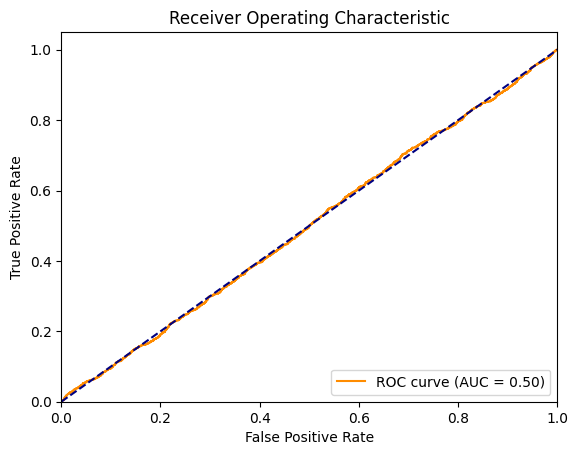

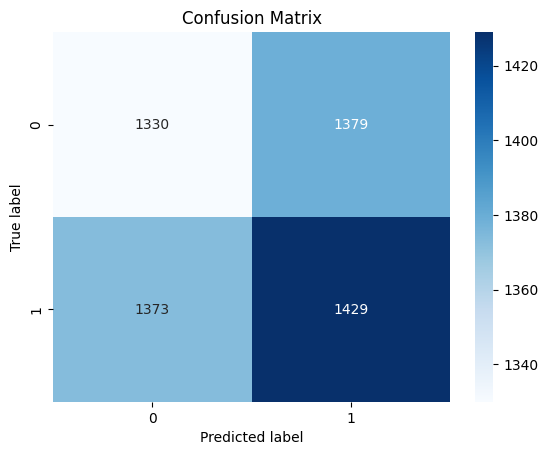

In [ ]:
# Evaluate the model on the validation data
validation_generator = val_ds
model_test_performace = model.evaluate(validation_generator)
model.save('model.h5')

# Generate predictions
y_pred = model.predict(val_ds)
y_true = []
for images, labels in validation_generator:
    y_true.extend(labels.numpy())

# Create ROC curve and calculate AUC
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
import matplotlib.pyplot as plt
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Create confusion matrix
from sklearn.metrics import confusion_matrix
y_pred_classes = (y_pred > 0.5).astype(int)
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
import seaborn as sns
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

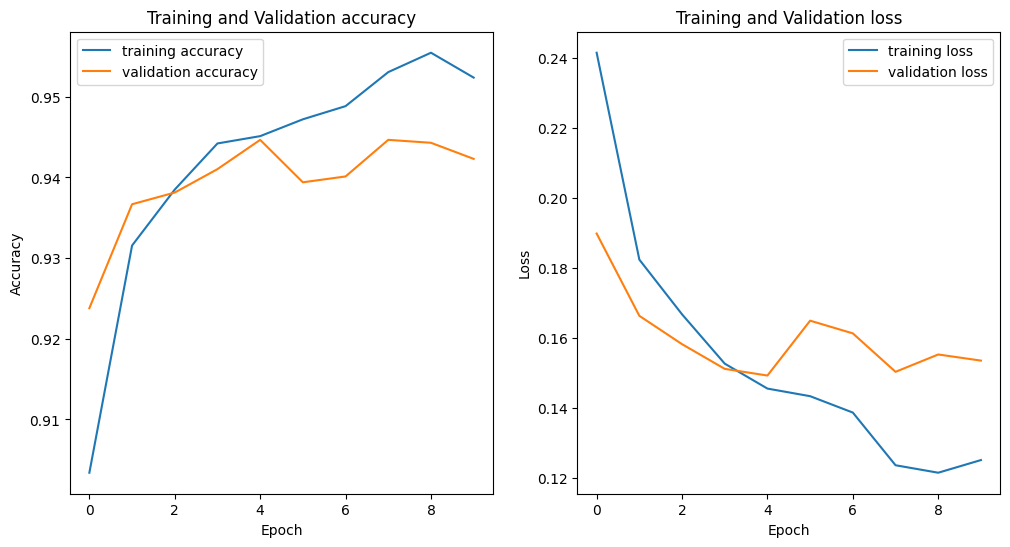

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(history.history['accuracy'], label='training accuracy')
ax[0].plot(history.history['val_accuracy'], label='validation accuracy')
ax[0].set_title('Training and Validation accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(history.history['loss'], label='training loss')
ax[1].plot(history.history['val_loss'], label='validation loss')
ax[1].set_title('Training and Validation loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.show()